In [10]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

simrun=100#0#600#0#00#0
duration = 1000#1000
nproc=350
L=cbrt(100)
Ca=5.
Cb=1.
k0= 0.1
method='multiprocessing'

def write(name,obs):
    f=open(name,'w')
    data = np.array(obs.data()).T
    np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
    f.close()        
    print('saving into',name)        

def singlerun(rm,D,solver='ode',intrinsic=False,simrun=1):   
    print(solver)
    V = L**3 
    Nb=int(Cb*V)
    M = max(int(min(cbrt(Nb), L / (2 * rm))), 3)            
    if solver=='spa':
        solver=("spatiocyte",rm*1.0208582)
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm*1.0208582)    
    elif solver=='G':
        solver = ("gillespie")
    elif solver=='egfrd':
        solver=('egfrd', Integer3(M, M, M))    
    elif solver=='meso':
        h=2*rm
        K = int(L/h)
        solver = ("meso",Integer3(K,K,K))        
        print('h',h,'K',K)
    Nb=int(Cb*V)
    keff = k0/Ca/Cb
    print('Nb',Nb)
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)
    #beta=0.30208 #K=2
    #beta=0.274#K=46
    #hc = keff*0.2527/D/2
    #keff = 1/(1/keff-beta/h/D/2)
    #print('modified k',keff,'h critical',hc,hc/rm/2)
    if intrinsic:
        assert(ka>0)
    with species_attributes():
        A | {'D': D, 'radius':rm*1.0208582  }
        B | {'D': D, 'radius':rm*1.0208582  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | (ka if intrinsic else keff)
    m = get_model()
    print('rm={:.3},D={:.3}'.format(rm,D))
    print('kon={:.3},ka={:.3},kd={:.3},keff={:.3},kfactor={:.3},V={:.3}'.format(k0,ka,kd,keff,ka/kd,V))
    if simrun >1    :
        obs=ensemble.ensemble_simulations(duration,n=simrun, y0={'B':Nb},model=m, solver=solver,volume=ones()*L,species_list=["A"],return_type='observer',nproc=nproc,method=method,path='tmp')#,return_type="observer")
    else:
        obs=run_simulation(duration,model=m,y0={'B':Nb},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
    data = np.array(obs.data()).T
    print('mean [A]',np.mean(data[1][50:])/V)   
    #write('/home/chew/outputdata/sturrock_bd_{}_rm{:.3}_D{:.3}_L{:.3}b'.format('spa',rm,D,L),obs)
    return obs

#obs1=singlerun(0.005,0.1,'ode',False,simrun)
#obs2=singlerun(0.005,0.1,'spa',True,simrun)
#obs3=singlerun(0.005,0.1,'egfrd',True,simrun)
#obs4=singlerun(0.005,0.1,'gillespie',False,simrun)
obs=singlerun(0.02,0.01,'spa',True,simrun)
#write('/home/chew/outputdata/sturrock_bd_ode_rm{:.3}_Nas5'.format(rm),obs1)
#write('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_10k'.format(rm),obs2)
#write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_10k'.format(rm),obs3)
#viz.plot_number_observer(obs2,'g-',obs1,'k-',obs3,'r-')    


spa
Nb 103


AssertionError: 

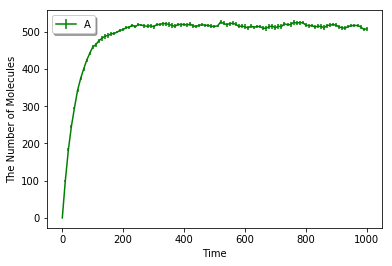

In [5]:
viz.plot_number_observer(obs,'g-')


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: genfromtxt: Empty input file: "/home/chew/outputdata/sturrock_bd_spa_rm0.005_D0.1_L4.64b_err"


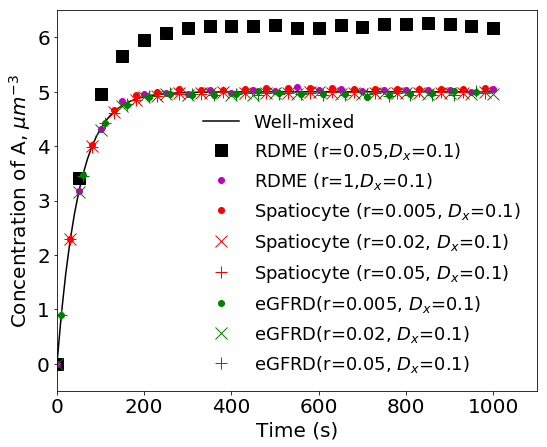

In [1]:
import numpy as np
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.pylab as plt
from ecell4 import *
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=20
ms=12
lw=3
lg=5
L=cbrt(100)

ode=np.genfromtxt('/home/chew/outputdata/sturrock_bd_ode_rm{}'.format(0.05),delimiter=',')
ax.plot(ode[:,0],ode[:,1],'k-',label='Well-mixed',markersize=ms)

meso = np.genfromtxt('/home/chew/outputdata/sturrock_bd_meso_rm0.05_D0.1_L4.64',delimiter=',')
ax.plot(meso[:,0][::lg],meso[:,1][::lg]/L**3,'ks',label='RDME (r=0.05,$D_x$=0.1)',markersize=ms)
meso = np.genfromtxt('/home/chew/outputdata/sturrock_bd_meso_rm1.0_D0.1_L4.64',delimiter=',')
ax.plot(meso[:,0][::lg],meso[:,1][::lg]/L**3,'m.',label='RDME (r=1,$D_x$=0.1)',markersize=ms)

meanspa=[]
data1=[[0.005,0.1,'r.','1.8hrs'],[0.02,0.1,'rx','1.4min'],[0.05,0.1,'r+','14s']]
for y in data1:
    fac=1.0208582
    V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),y[0]*fac)  
    d=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm{}_D{}_L4.64b'.format(y[0],y[1]),delimiter=',')
    e=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm{}_D{}_L4.64b_err'.format(y[0],y[1]),delimiter=',')
    mean=np.mean(d[:,1][50:])/V
    meanspa.append([mean,y[0],y[1]])
    ax.plot(d[:,0][3::lg],d[:,1][3::lg]/V,y[2],label='Spatiocyte (r={}, $D_x$={})'.format(y[0],y[1],y[-1]),markersize=ms)

datae=[[0.005,0.1,'g.','9.5hrs'],[0.02,0.1,'gx','2hrs'],[0.05,0.1,'g+','4hrs']]
meane=[]
for y in datae:
    L=cbrt(100)
    V=L**3
    d=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{}_D{}_L4.64'.format(y[0],y[1]),delimiter=',',skip_header=1)
    meane.append([np.mean(d[:,1][50:])/V,y[0],y[1]])    
    ax.plot(d[:,0][::lg],d[:,1][::lg]/V,y[2],label='eGFRD(r={}, $D_x$={})'.format(y[0],y[1],y[-1]),markersize=ms)

ax.set_xlim(0,1100)
ax.set_ylim(-0.5,6.5)
ax.tick_params(labelsize=fs)
ax.set_xlabel('Time (s)',fontsize=fs)
ax.set_ylabel('Concentration of A, $\mu m^{-3}$',fontsize=fs)
plt.legend(loc='best',fontsize=fs-2,frameon=False)
plt.savefig('/home/chew/ecellwork/figure/fig5a',format='pdf',dpi=800)


In [15]:
k0=0.1
D=0.1
Ca=5
Cb=1
keff = k0/Ca/Cb
rm=np.array([0.05,0.02,0.005])
kd = 4*np.pi*rm*2*D*2
ka = keff*kd/(kd-keff)
for i,j in zip(rm,ka):
    print('rm=',i,'ka',j)
with reaction_rules():
    ~A > A | k0
    A + B >B | ka

rm= 0.05 ka 0.02172915088637838
rm= 0.02 ka 0.024967033493549055
rm= 0.005 ka 0.09793106688526364


In [28]:
import math
kf=0.01
for kf in [0.001,1,100]:
    D=10
    rm=0.005
    R=2*rm
    kd=4*math.pi*R*D
    ka=kf*kd
    keff = ka*kd/(ka+kd)
    print(keff,hc/R)
    hc = keff*0.2527/D/2


0.0012553816797561612 1.5720405219052294
0.6283185307179586 0.0015861747523719094
1.2441951103325912 0.7938804635621407
